In [39]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [40]:
DATA_PATH = r'C:\Users\User\Desktop\abide'

In [41]:
print(f"Загрузка данных из: {DATA_PATH}")

pheno_train = pd.read_csv(os.path.join(DATA_PATH, 'pheno_train.csv'))
pheno_test = pd.read_csv(os.path.join(DATA_PATH, 'pheno_test.csv'))

print(f"Train: {pheno_train.shape}, Test: {pheno_test.shape}")

pheno_train['dataset'] = 'train'
pheno_test['dataset'] = 'test'

pheno_all = pd.concat([pheno_train, pheno_test], ignore_index=True)

Загрузка данных из: C:\Users\User\Desktop\abide
Train: (931, 104), Test: (104, 103)


In [42]:
pheno_train.head()

,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,dataset
0,814,51131,815,51131,NYU,NYU_0051131,2,19.7300,1,NaN,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,train
1,162,50237,163,50237,TRINITY,Trinity_0050237,1,21.4200,1,R,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,train
2,863,51185,864,51185,STANFORD,Stanford_0051185,2,8.2464,1,R,...,maybe,skull-striping fail;,OK,NaN,OK,NaN,OK,NaN,1,train
3,668,50978,669,50978,NYU,NYU_0050978,1,9.5800,1,NaN,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0,train
4,508,50653,509,50653,CMU,CMU_a_0050653,1,30.0000,1,R,...,OK,NaN,fail,ic-frontal-temporal-cerebellum,OK,NaN,OK,NaN,0,train


In [43]:
print("АНАЛИЗ СТРУКТУРЫ HDF5")

h5_path = os.path.join(DATA_PATH, 'abide.hdf5')
with h5py.File(h5_path, 'r') as f:
    top_level = list(f.keys())
    print(f"Группы верхнего уровня: {top_level}")

    if 'patients' in f:
        patients_group = f['patients']
        patient_ids = list(patients_group.keys())
        print(f"\nНайдено пациентов: {len(patient_ids)}")
        print(f"Примеры ID: {patient_ids[:5]}")

        sample_patient = patient_ids[0]
        print(f"\nСтруктура для пациента {sample_patient}:")
        for key in patients_group[sample_patient].keys():
            dataset = patients_group[sample_patient][key]
            print(f"  {key}: форма {dataset.shape}, тип {dataset.dtype}")

        available_atlases = list(patients_group[sample_patient].keys())
        print(f"\nДоступные атласы: {available_atlases}\n")

def print_first_patients(h5_file, n_patients=5):
    """
    Выводит структуру для первых N пациентов
    """
    with h5py.File(h5_file, 'r') as f:
        print(f"📁 /")

        for key in f.keys():
            print(f"  📁 {key}/")

            if key == 'patients':
                patients = f[key]
                all_patients = list(patients.keys())

                print(f"    Всего пациентов: {len(all_patients)}")
                print(f"    Первые {n_patients} пациентов:")

                for patient_id in all_patients[:n_patients]:
                    print(f"      📁 {patient_id}/")
                    patient = patients[patient_id]

                    for atlas in patient.keys():
                        data = patient[atlas]
                        print(f"        📊 {atlas}: {data.shape}")


print_first_patients(h5_path, n_patients=3)

АНАЛИЗ СТРУКТУРЫ HDF5
Группы верхнего уровня: ['patients']

Найдено пациентов: 1035
Примеры ID: ['CMU_a_0050642', 'CMU_a_0050646', 'CMU_a_0050647', 'CMU_a_0050649', 'CMU_a_0050653']

Структура для пациента CMU_a_0050642:
  aal: форма (6670,), тип float64
  dosenbach160: форма (12880,), тип float64
  ez: форма (6670,), тип float64
  ho: форма (6105,), тип float64
  tt: форма (4656,), тип float64

Доступные атласы: ['aal', 'dosenbach160', 'ez', 'ho', 'tt']

📁 /
  📁 patients/
    Всего пациентов: 1035
    Первые 3 пациентов:
      📁 CMU_a_0050642/
        📊 aal: (6670,)
        📊 dosenbach160: (12880,)
        📊 ez: (6670,)
        📊 ho: (6105,)
        📊 tt: (4656,)
      📁 CMU_a_0050646/
        📊 aal: (6670,)
        📊 dosenbach160: (12880,)
        📊 ez: (6670,)
        📊 ho: (6105,)
        📊 tt: (4656,)
      📁 CMU_a_0050647/
        📊 aal: (6670,)
        📊 dosenbach160: (12880,)
        📊 ez: (6670,)
        📊 ho: (6105,)
        📊 tt: (4656,)


In [44]:
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ФЕДЕРАТИВНОГО ОБУЧЕНИЯ")

split_col = site_col
print(f"Разделение по колонке: {split_col}")

train_data = pheno_train[pheno_train[split_col].notna()].copy()
train_data['age_group'] = pd.cut(train_data['AGE_AT_SCAN'], bins=[0, 18, 200], labels=['under_18', '18_and_over'])

atlas = 'aal'
print(f"\nИспользуем атлас: {atlas}\nИзвлечение данных из HDF5...")

clients, client_info, age_stats = {}, [], []

with h5py.File(h5_path, 'r') as f:
    patients_group, h5_ids = f['patients'], list(f['patients'].keys())
    print(f"Всего ID в HDF5: {len(h5_ids)}")

    for site, group in train_data.groupby(split_col):
        subject_ids, n_subjects = group['SUB_ID'].astype(str).tolist(), len(group)

        X_list, y_list, not_found = [], [], []
        under_18_count = over_18_count = 0
        age_map = group.set_index('SUB_ID')['age_group'].to_dict()
        dx_map = group.set_index('SUB_ID')['DX_GROUP'].to_dict()

        for sub_id in subject_ids:
            found = False
            for h5_id in h5_ids:
                if sub_id in h5_id or h5_id.endswith(sub_id) or h5_id.startswith(sub_id) or sub_id.zfill(7) in h5_id:
                    if atlas in patients_group[h5_id]:
                        data = patients_group[h5_id][atlas][:]
                        X_list.append(data); y_list.append(dx_map[int(sub_id)])
                        if age_map[int(sub_id)] == 'under_18': under_18_count += 1
                        else: over_18_count += 1
                        found = True; break
            if not found: not_found.append(sub_id)

        if len(X_list) >= 5:
            X, y = np.array(X_list), np.array(y_list)
            clients[site] = (X, y)
            unique, counts = np.unique(y, return_counts=True)
            class_counts = dict(zip(unique, counts))

            client_info.append({'site': site, 'n_subjects': len(X), 'n_total': n_subjects,
                'asd_count': class_counts.get(1,0), 'control_count': class_counts.get(2,0),
                'data_shape': str(X.shape), 'not_found': len(not_found),
                'under_18': under_18_count, 'over_18': over_18_count})

            age_stats.append({'site': site, 'under_18': under_18_count,
                            'over_18': over_18_count, 'total': len(X)})

print(f"\n✅ Создано {len(clients)} клиентов")

ПОДГОТОВКА ДАННЫХ ДЛЯ ФЕДЕРАТИВНОГО ОБУЧЕНИЯ
Разделение по колонке: SITE_ID

Используем атлас: aal
Извлечение данных из HDF5...
Всего ID в HDF5: 1035

✅ Создано 20 клиентов


ПОДСЧЕТ ВОЗРАСТНЫХ ГРУПП

📊 ОБЩАЯ СТАТИСТИКА: Всего пациентов: 931
   Младше 18: 648 (69.6%)
   18+: 283 (30.4%)

📊 СТАТИСТИКА ПО КАЖДОМУ САЙТУ:

   mNYU: Всего: 162,
   До 18: 119 (73.5%),
   18+: 43 (26.5%)

   mUM_1: Всего: 95,
   До 18: 88 (92.6%),
   18+: 7 (7.4%)

   mUCLA_1: Всего: 65,
   До 18: 65 (100.0%),
   18+: 0 (0.0%)

   mUSM: Всего: 63,
   До 18: 23 (36.5%),
   18+: 40 (63.5%)

   mPITT: Всего: 52,
   До 18: 28 (53.8%),
   18+: 24 (46.2%)

   mYALE: Всего: 50,
   До 18: 50 (100.0%),
   18+: 0 (0.0%)

   mMAX_MUN: Всего: 47,
   До 18: 14 (29.8%),
   18+: 33 (70.2%)

   mTRINITY: Всего: 43,
   До 18: 26 (60.5%),
   18+: 17 (39.5%)

   mKKI: Всего: 42,
   До 18: 42 (100.0%),
   18+: 0 (0.0%)

   mSTANFORD: Всего: 35,
   До 18: 35 (100.0%),
   18+: 0 (0.0%)

   mCALTECH: Всего: 33,
   До 18: 2 (6.1%),
   18+: 31 (93.9%)

   mSDSU: Всего: 33,
   До 18: 33 (100.0%),
   18+: 0 (0.0%)

   mUM_2: Всего: 29,
   До 18: 27 (93.1%),
   18+: 2 (6.9%)

   mSBL: Всего: 29,
   До 18: 0 

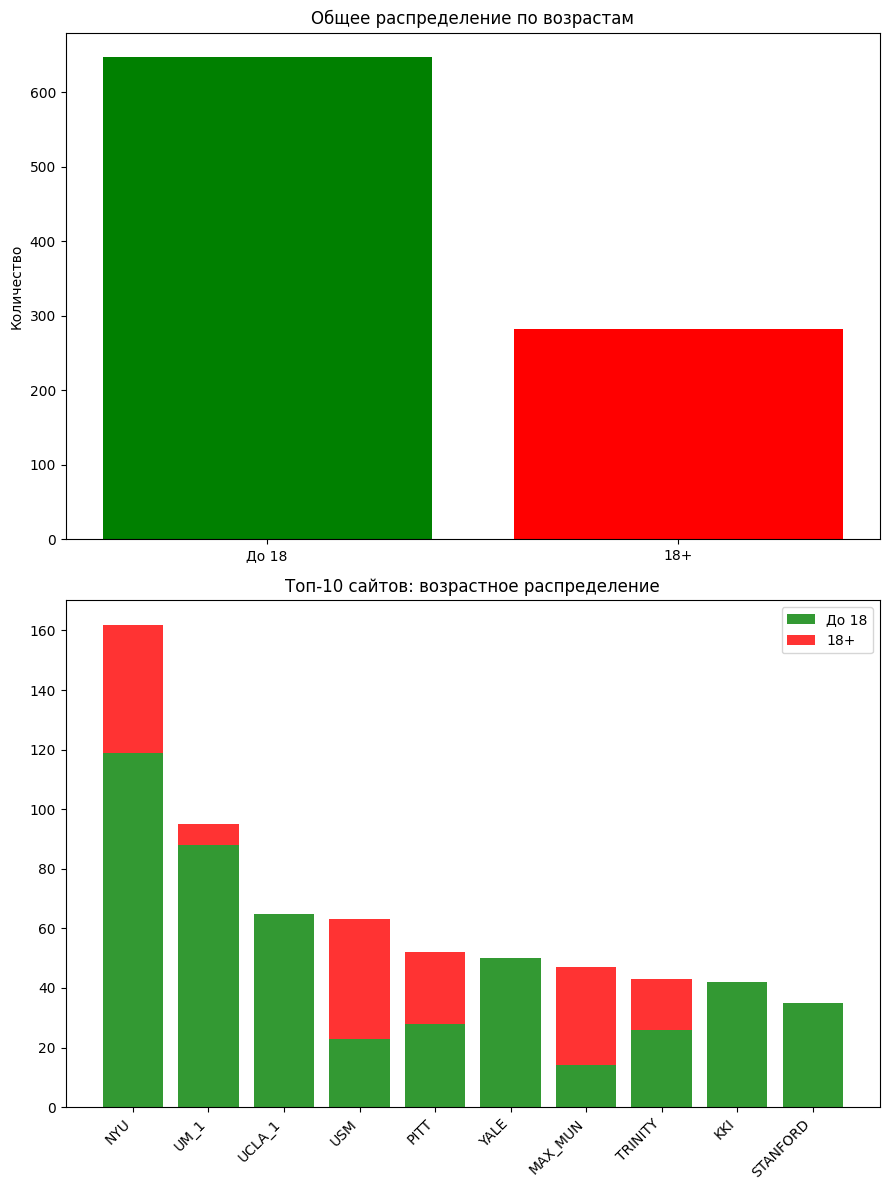

In [46]:
print("ПОДСЧЕТ ВОЗРАСТНЫХ ГРУПП")

age_df = pd.DataFrame(age_stats)
total_under, total_over, total_patients = age_df['under_18'].sum(), age_df['over_18'].sum(), age_df['total'].sum()

print(f"\n📊 ОБЩАЯ СТАТИСТИКА: Всего пациентов: {total_patients}")
print(f"   Младше 18: {total_under} ({total_under/total_patients*100:.1f}%)")
print(f"   18+: {total_over} ({total_over/total_patients*100:.1f}%)")

print(f"\n📊 СТАТИСТИКА ПО КАЖДОМУ САЙТУ:")
for _, row in age_df.sort_values('total', ascending=False).iterrows():
    print(f"\n   m{row['site']}: Всего: {row['total']},\n   До 18: {row['under_18']} ({row['under_18']/row['total']*100:.1f}%),\n   18+: {row['over_18']} ({row['over_18']/row['total']*100:.1f}%)")

fig, axes = plt.subplots(2, figsize=(9, 12))
axes[0].bar(['До 18', '18+'], [total_under, total_over], color=['green', 'red'])
axes[0].set_title('Общее распределение по возрастам'); axes[0].set_ylabel('Количество')

top10 = age_df.nlargest(10, 'total')
x = range(len(top10))
axes[1].bar(x, top10['under_18'], label='До 18', color='green', alpha=0.8)
axes[1].bar(x, top10['over_18'], bottom=top10['under_18'], label='18+', color='red', alpha=0.8)
axes[1].set_xticks(x); axes[1].set_xticklabels(top10['site'], rotation=45, ha='right')
axes[1].set_title('Топ-10 сайтов: возрастное распределение'); axes[1].legend()

plt.tight_layout(); plt.show()

Дополнительный анализ

In [47]:
with h5py.File(h5_path, 'r') as f:
    patients = f['patients']
    h5_ids = set(patients.keys())

    csv_ids = set()
    for sub_id in pheno_train['SUB_ID']:
        csv_ids.add(f"{sub_id:07d}")
        csv_ids.add(str(sub_id))

    found = 0
    not_found = []

    for h5_id in h5_ids:
        for csv_id in csv_ids:
            if csv_id in h5_id:
                found += 1
                break

    print(f"Пациентов в HDF5: {len(h5_ids)}")
    print(f"Найдено соответствий с CSV: {found}")
    print(f"Процент покрытия: {found/len(pheno_train)*100:.1f}%")

Пациентов в HDF5: 1035
Найдено соответствий с CSV: 931
Процент покрытия: 100.0%


In [48]:
print("РАЗВЕДОЧНЫЙ АНАЛИЗ CSV ДАННЫХ")

print(f"\nВсего субъектов: {len(pheno_all)}")
print(f"Обучающая выборка: {len(pheno_train)}")
print(f"Тестовая выборка: {len(pheno_test)}")

missing = pheno_all.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nТоп-10 колонок с пропусками:")
print(missing.head(10))

print("\nКолонки с < 10% пропусков:")
useful_cols = missing_pct[missing_pct < 10]
print(useful_cols.head(20))

print("\nРаспределение DX_GROUP в train:")
dx_counts = pheno_train['DX_GROUP'].value_counts().sort_index()
for val, count in dx_counts.items():
    print(f"  Группа {val}: {count} ({count/len(pheno_train)*100:.1f}%)")

РАЗВЕДОЧНЫЙ АНАЛИЗ CSV ДАННЫХ

Всего субъектов: 1035
Обучающая выборка: 931
Тестовая выборка: 104

Топ-10 колонок с пропусками:
qc_func_notes_rater_3     1033
qc_notes_rater_1           997
WISC_IV_WMI                987
WISC_IV_VCI                987
WISC_IV_PRI                987
WISC_IV_PSI                987
WISC_IV_SIM_SCALED         987
WISC_IV_LET_NUM_SCALED     987
WISC_IV_PIC_CON_SCALED     987
WISC_IV_SYM_SCALED         987
dtype: int64

Колонки с < 10% пропусков:
FIQ             2.792696
func_fwhm       0.107411
func_perc_fd    0.107411
func_quality    0.107411
func_dvars      0.107411
func_outlier    0.107411
func_fber       0.107411
func_gsr        0.107411
func_mean_fd    0.107411
func_num_fd     0.107411
anat_fber       0.107411
anat_snr        0.107411
func_efc        0.107411
anat_cnr        0.107411
anat_fwhm       0.107411
anat_efc        0.107411
anat_qi1        0.107411
SEX             0.000000
SUB_ID          0.000000
X               0.000000
dtype: float64

Распр

ВИЗУАЛИЗАЦИЯ КЛИЕНТОВ

Информация о клиентах:
    site  n_subjects  asd_count  control_count  not_found
     NYU         162         68             94          0
    UM_1          95         45             50          0
  UCLA_1          65         40             25          0
     USM          63         41             22          0
    PITT          52         28             24          0
    YALE          50         24             26          0
 MAX_MUN          47         23             24          0
 TRINITY          43         21             22          0
     KKI          42         18             24          0
STANFORD          35         18             17          0
 CALTECH          33         17             16          0
    SDSU          33         11             22          0
    UM_2          29          9             20          0
     SBL          29         15             14          0
    OLIN          28         14             14          0
LEUVEN_2          26      

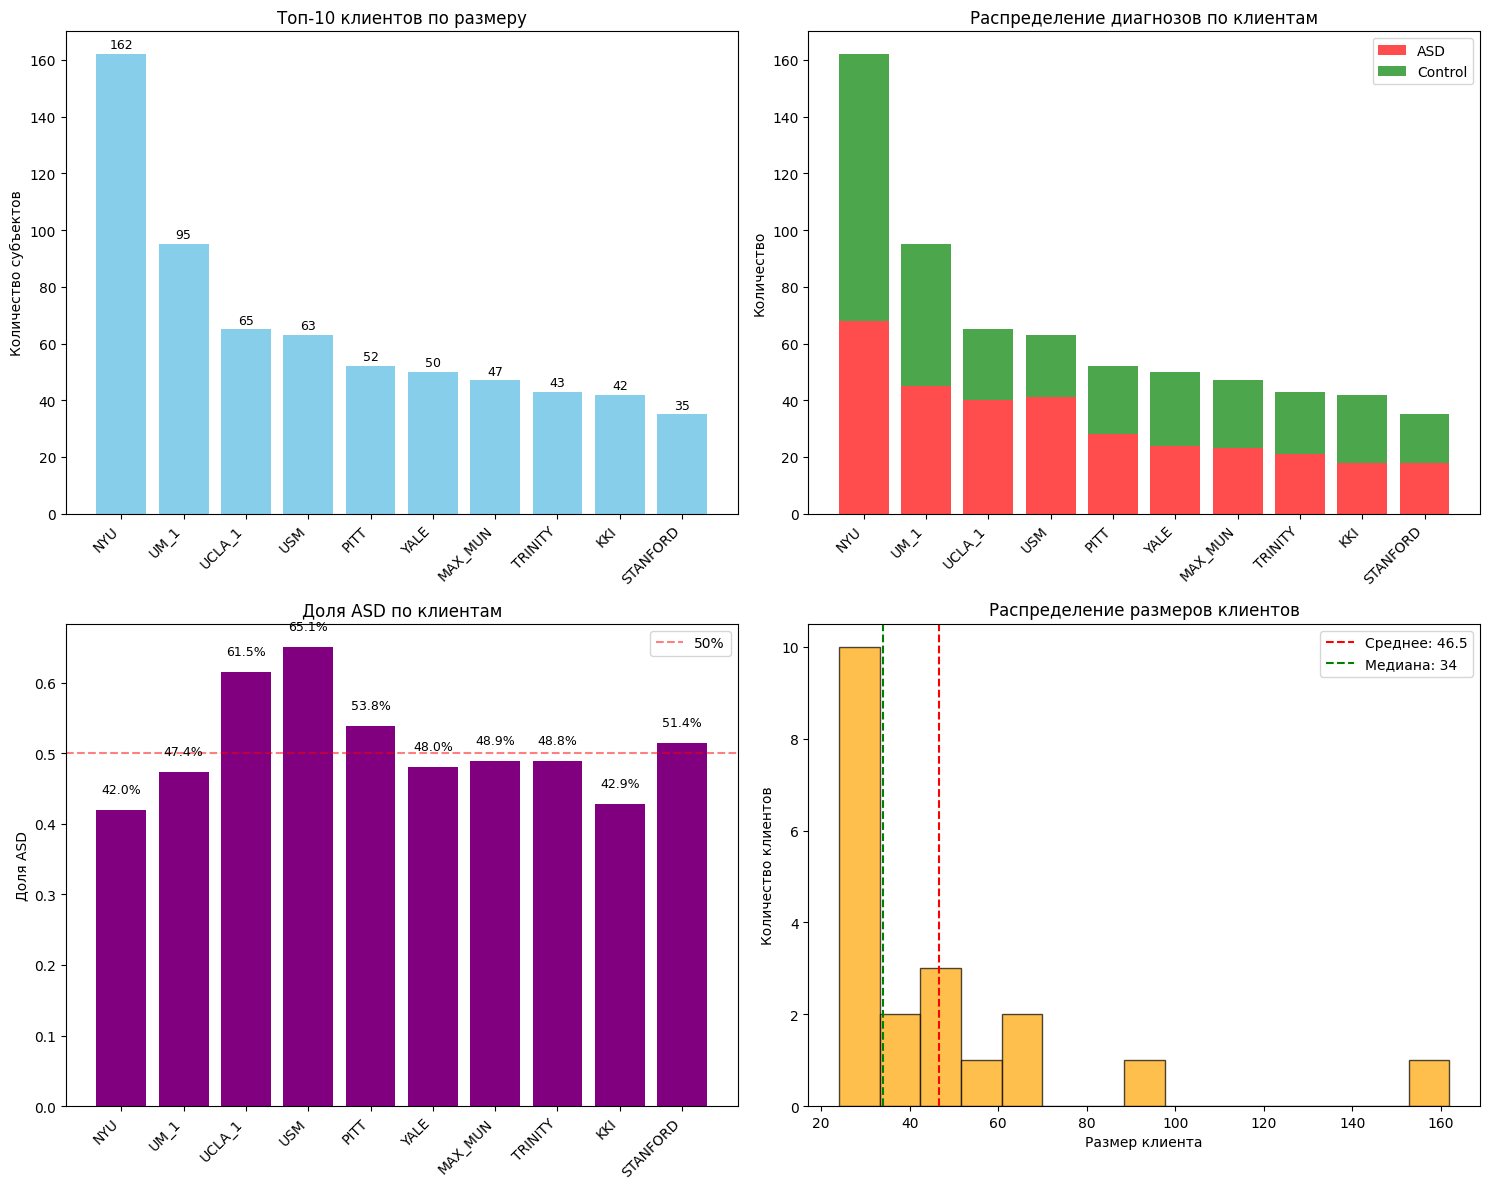

In [49]:
print("ВИЗУАЛИЗАЦИЯ КЛИЕНТОВ")

if clients:
    clients_df = pd.DataFrame(client_info)
    clients_df = clients_df.sort_values('n_subjects', ascending=False)

    print("\nИнформация о клиентах:")
    print(clients_df[['site', 'n_subjects', 'asd_count', 'control_count', 'not_found']].to_string(index=False))

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Размеры клиентов
    ax1 = axes[0, 0]
    top_sites = clients_df.head(10)['site'].tolist()
    top_sizes = clients_df.head(10)['n_subjects'].tolist()
    bars = ax1.bar(range(len(top_sites)), top_sizes, color='skyblue')
    ax1.set_xticks(range(len(top_sites)))
    ax1.set_xticklabels([s[:10] for s in top_sites], rotation=45, ha='right')
    ax1.set_title('Топ-10 клиентов по размеру')
    ax1.set_ylabel('Количество субъектов')

    for i, (bar, val) in enumerate(zip(bars, top_sizes)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(val), ha='center', va='bottom', fontsize=9)

    # 2. Распределение ASD/Control
    ax2 = axes[0, 1]
    x = range(len(top_sites))
    asd_vals = clients_df.head(10)['asd_count'].tolist()
    control_vals = clients_df.head(10)['control_count'].tolist()

    ax2.bar(x, asd_vals, label='ASD', color='red', alpha=0.7)
    ax2.bar(x, control_vals, bottom=asd_vals, label='Control', color='green', alpha=0.7)
    ax2.set_xticks(x)
    ax2.set_xticklabels([s[:10] for s in top_sites], rotation=45, ha='right')
    ax2.set_title('Распределение диагнозов по клиентам')
    ax2.set_ylabel('Количество')
    ax2.legend()

    # 3. Доля ASD
    ax3 = axes[1, 0]
    asd_ratios = (clients_df.head(10)['asd_count'] / clients_df.head(10)['n_subjects']).tolist()
    bars = ax3.bar(range(len(top_sites)), asd_ratios, color='purple')
    ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50%')
    ax3.set_xticks(range(len(top_sites)))
    ax3.set_xticklabels([s[:10] for s in top_sites], rotation=45, ha='right')
    ax3.set_title('Доля ASD по клиентам')
    ax3.set_ylabel('Доля ASD')
    ax3.legend()

    for i, (bar, ratio) in enumerate(zip(bars, asd_ratios)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{ratio:.1%}', ha='center', va='bottom', fontsize=9)

    # 4. Гистограмма размеров клиентов
    ax4 = axes[1, 1]
    ax4.hist(clients_df['n_subjects'], bins=15, edgecolor='black', alpha=0.7, color='orange')
    ax4.set_title('Распределение размеров клиентов')
    ax4.set_xlabel('Размер клиента')
    ax4.set_ylabel('Количество клиентов')
    ax4.axvline(clients_df['n_subjects'].mean(), color='red', linestyle='--',
                label=f"Среднее: {clients_df['n_subjects'].mean():.1f}")
    ax4.axvline(clients_df['n_subjects'].median(), color='green', linestyle='--',
                label=f"Медиана: {clients_df['n_subjects'].median():.0f}")
    ax4.legend()

    plt.tight_layout()
    plt.show()

else:
    print("❌ Не удалось создать клиентов. Проверьте соответствие ID в CSV и HDF5.")